In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


2025-04-10 09:38:13.119095: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
df = pd.read_csv("cleaned_US_cases_and_deaths.csv", parse_dates=['Date'])

df = df[~df['Date'].dt.year.eq(2023)]

# group by month and sum cases
monthly_df = df.groupby(pd.Grouper(key='Date', freq='M'))[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']].sum().reset_index()

# normalize case values
scaler_month = MinMaxScaler()
features_scaled_month = scaler_month.fit_transform(monthly_df[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']])

# create time series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length][0])
    return np.array(X), np.array(y)

seq_length = 4  # number of months to look back
X_month, y_month = create_sequences(features_scaled_month, seq_length)
X_month = X_month.reshape((X_month.shape[0], X_month.shape[1], features_scaled_month.shape[1]))

model_month = Sequential()
model_month.add(LSTM(50, activation='relu', input_shape=(seq_length, X_month.shape[2])))
model_month.add(Dense(1))
model_month.compile(optimizer='adam', loss='mse')
model_month.fit(X_month, y_month, epochs=100, verbose=1)

y_pred_month = model_month.predict(X_month)

y_pred_full = np.zeros((len(y_pred_month), features_scaled_month.shape[1]))
y_pred_full[:, 0] = y_pred_month.flatten()  # only 'Cases' column

y_true_full = np.zeros((len(y_month), features_scaled_month.shape[1]))
y_true_full[:, 0] = y_month.flatten()

y_pred_inverse_month = scaler_month.inverse_transform(y_pred_full)[:, 0]
y_true_inverse_month = scaler_month.inverse_transform(y_true_full)[:, 0]



In [14]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluation metrics
mse_m = mean_squared_error(y_true_inverse_month, y_pred_inverse_month)
rmse_m = np.sqrt(mse_m)
mae_m = mean_absolute_error(y_true_inverse_month, y_pred_inverse_month)
r2_m = r2_score(y_true_inverse_month, y_pred_inverse_month)
n_m = len(y_true_inverse_month)
p_m = 1
adjusted_r2_m = 1 - (1 - r2_m) * (n_m - 1) / (n_m - p_m - 1)

print("📅 Monthly Model Evaluation Metrics:")
print(f"📉 MSE: {mse_m:.2f}")
print(f"📈 RMSE: {rmse_m:.2f}")
print(f"📊 MAE: {mae_m:.2f}")
print(f"🧠 R² Score: {r2_m:.4f}")
print(f"🧮 Adjusted R² Score: {adjusted_r2_m:.4f}")

📅 Monthly Model Evaluation Metrics:
📉 MSE: 21426338354341728.00
📈 RMSE: 146377383.34
📊 MAE: 115092529.71
🧠 R² Score: 0.9793
🧮 Adjusted R² Score: 0.9786


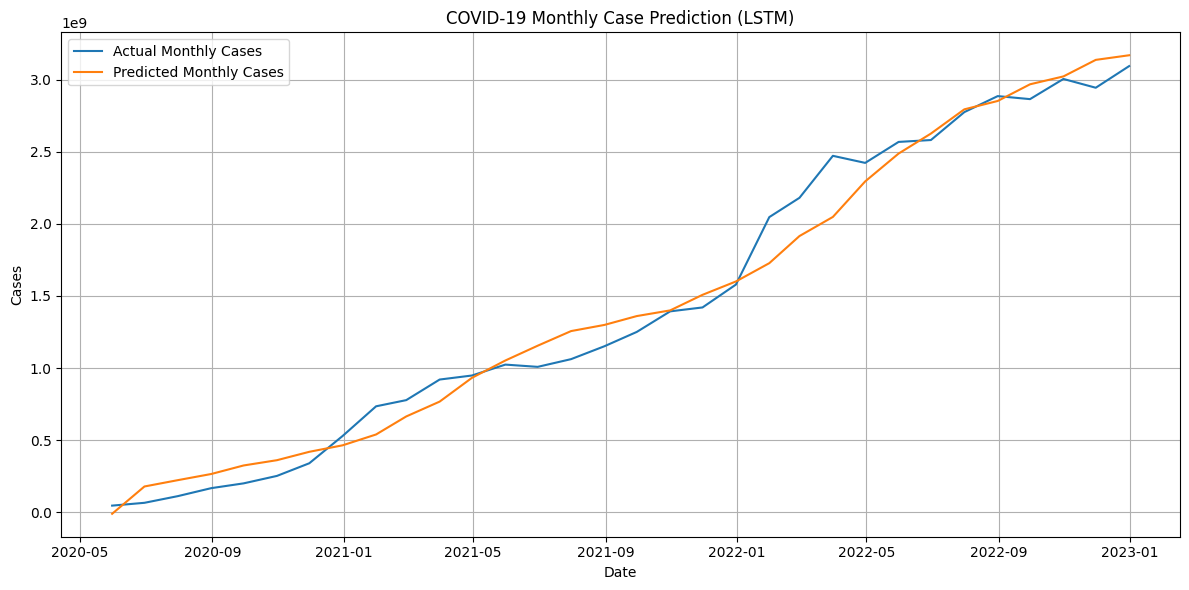

In [15]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_df['Date'][seq_length:], y_true_inverse_month, label='Actual Monthly Cases')
plt.plot(monthly_df['Date'][seq_length:], y_pred_inverse_month, label='Predicted Monthly Cases')
plt.title("COVID-19 Monthly Case Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

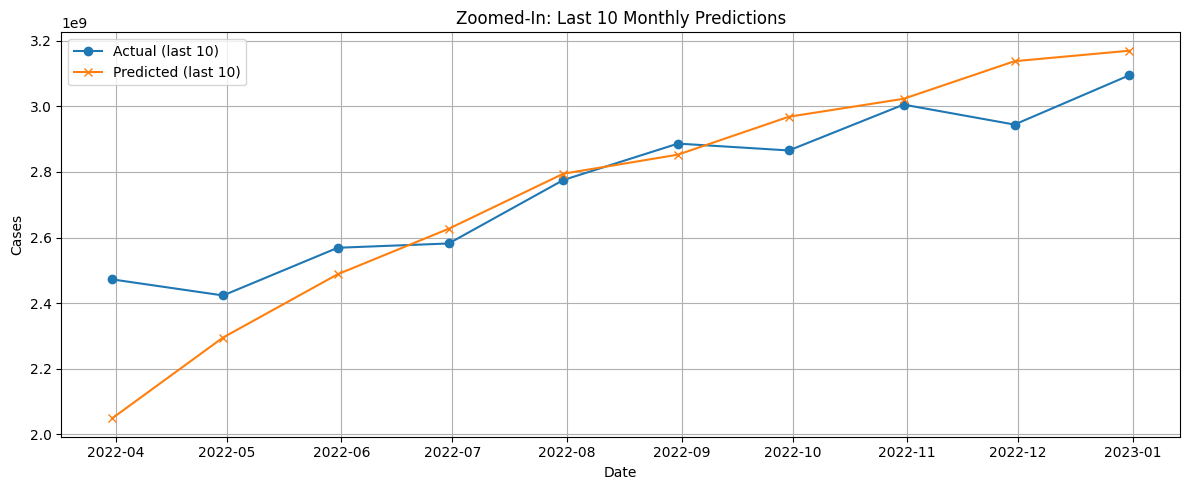

In [16]:
plt.figure(figsize=(12, 5))
plt.plot(monthly_df['Date'][seq_length:][-10:], y_true_inverse_month[-10:], marker='o', label='Actual (last 10)')
plt.plot(monthly_df['Date'][seq_length:][-10:], y_pred_inverse_month[-10:], marker='x', label='Predicted (last 10)')
plt.title("Zoomed-In: Last 10 Monthly Predictions")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [20]:
df = pd.read_csv("cleaned_US_cases_and_deaths.csv", parse_dates=['Date'])

df = df[~df['Date'].dt.year.eq(2023)]

# group by month and sum cases
monthly_death_df = df.groupby(pd.Grouper(key='Date', freq='M'))[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']].sum().reset_index()

# normalize case values
scaler_month = MinMaxScaler()
features_scaled_month = scaler_month.fit_transform(monthly_death_df[['Cases', 'Deaths', 'Lat', 'Long_', 'Population']])

# create time series sequences
def create_sequences(data, seq_length, target_index = 1):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, target_index])
    return np.array(X), np.array(y)

seq_length = 4  # number of months to look back
X_month, y_month = create_sequences(features_scaled_month, seq_length)
X_month = X_month.reshape((X_month.shape[0], X_month.shape[1], features_scaled_month.shape[1]))


model_month = Sequential()
model_month.add(LSTM(50, activation='relu', input_shape=(seq_length, X_month.shape[2])))
model_month.add(Dense(1))
model_month.compile(optimizer='adam', loss='mse')
model_month.fit(X_month, y_month, epochs=100, verbose=1)

y_pred_month = model_month.predict(X_month)
# Inverse transform for predictions
y_pred_full = np.zeros((len(y_pred_month), features_scaled_month.shape[1]))
y_pred_full[:, 1] = y_pred_month.flatten()  # index 1 corresponds to 'Deaths'
y_pred_inverse_month = scaler_month.inverse_transform(y_pred_full)[:, 1]  # Extract only the 'Deaths' column

# Inverse transform for ground truth
y_true_full = np.zeros((len(y_month), features_scaled_month.shape[1]))
y_true_full[:, 1] = y_month
y_true_inverse_month = scaler_month.inverse_transform(y_true_full)[:, 1]  # Extract only the 'Deaths' column





Epoch 1/100
1/1 [==============================] - 0s 472ms/step - loss: 0.4319
Epoch 2/100
1/1 [==============================] - 0s 2ms/step - loss: 0.4008
Epoch 3/100
1/1 [==============================] - 0s 3ms/step - loss: 0.3710
Epoch 4/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3424
Epoch 5/100
1/1 [==============================] - 0s 2ms/step - loss: 0.3150
Epoch 6/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2888
Epoch 7/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2639
Epoch 8/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2402
Epoch 9/100
1/1 [==============================] - 0s 2ms/step - loss: 0.2179
Epoch 10/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1969
Epoch 11/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1773
Epoch 12/100
1/1 [==============================] - 0s 2ms/step - loss: 0.1589
Epoch 13/100
1/1 [==============================] - 0s 2ms/

In [21]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# evaluation metrics
d_mse_m = mean_squared_error(y_true_inverse_month, y_pred_inverse_month)
d_rmse_m = np.sqrt(mse_m)
d_mae_m = mean_absolute_error(y_true_inverse_month, y_pred_inverse_month)
d_r2_m = r2_score(y_true_inverse_month, y_pred_inverse_month)
d_n_m = len(y_true_inverse_month)
d_p_m = 1
d_adjusted_r2_m = 1 - (1 - d_r2_m) * (d_n_m - 1) / (d_n_m - d_p_m - 1)

print("📅 Monthly Model Evaluation Metrics:")
print(f"📉 MSE: {d_mse_m:.2f}")
print(f"📈 RMSE: {d_rmse_m:.2f}")
print(f"📊 MAE: {d_mae_m:.2f}")
print(f"🧠 R² Score: {d_r2_m:.4f}")
print(f"🧮 Adjusted R² Score: {d_adjusted_r2_m:.4f}")

📅 Monthly Model Evaluation Metrics:
📉 MSE: 2522711887888.58
📈 RMSE: 146377383.34
📊 MAE: 1322697.11
🧠 R² Score: 0.9753
🧮 Adjusted R² Score: 0.9745


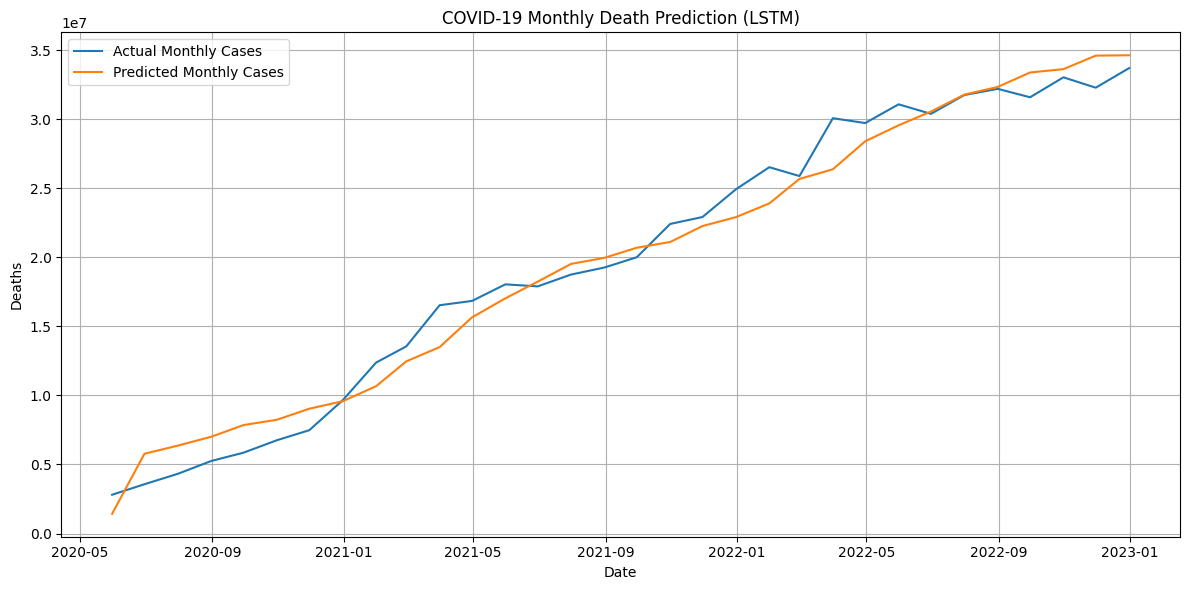

In [24]:
plt.figure(figsize=(12, 6))
plt.plot(monthly_death_df['Date'][seq_length:], y_true_inverse_month, label='Actual Monthly Cases')
plt.plot(monthly_death_df['Date'][seq_length:], y_pred_inverse_month, label='Predicted Monthly Cases')
plt.title("COVID-19 Monthly Death Prediction (LSTM)")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

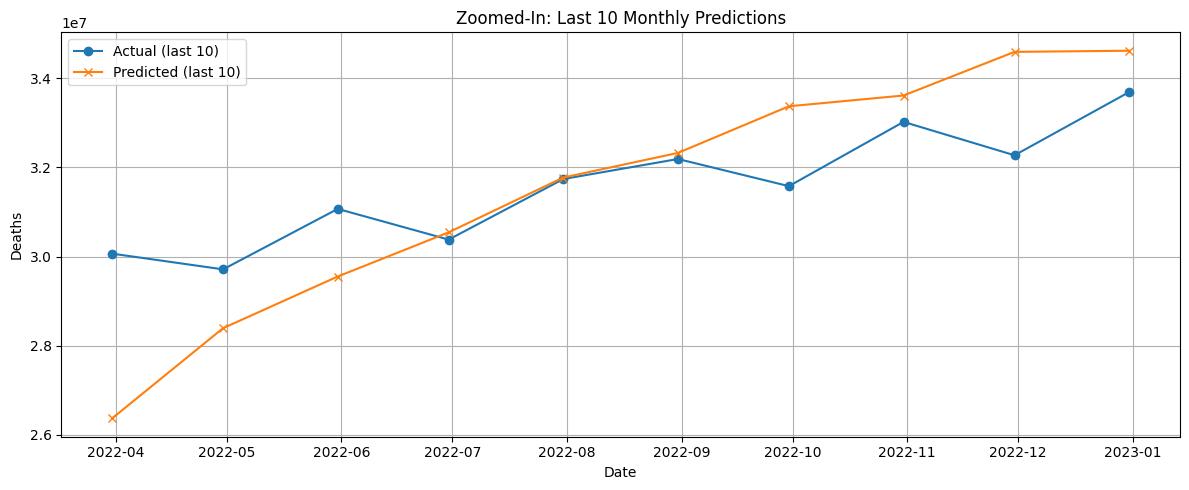

In [26]:
plt.figure(figsize=(12, 5))
plt.plot(monthly_death_df['Date'][seq_length:][-10:], y_true_inverse_month[-10:], marker='o', label='Actual (last 10)')
plt.plot(monthly_death_df['Date'][seq_length:][-10:], y_pred_inverse_month[-10:], marker='x', label='Predicted (last 10)')
plt.title("Zoomed-In: Last 10 Monthly Predictions")
plt.xlabel("Date")
plt.ylabel("Deaths")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()